In [1]:
import sys
import os
import struct
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import scipy, matplotlib
print ('Scipy Version:',scipy.__version__)
print ('Matplotlib version:',matplotlib.__version__)

Scipy Version: 0.19.1
Matplotlib version: 3.0.3


## 1. Prm file handling/Reading Class:

In [2]:
# adjunct1000 structure
class Adjunct1000:
  xstart = 0
  xdelta = 0
  xunits = 0

# HCB structure
class HCB:
  version = None    #fread(fid, 4, '*char')';
  head_rep = None   #fread(fid, 4, '*char')';
  data_rep = None   #fread(fid, 4, '*char')';
  detached = False  #fread(fid, 1, 'int32');
  protected = False #fread(fid, 1, 'int32');
  pipe = 0          #fread(fid, 1, 'int32');
  ext_start = 0     #fread(fid, 1, 'int32') * 512;
  ext_size = 0      #fread(fid, 1, 'int32');
  data_start = 0    #fread(fid, 1, 'double');
  data_size = 0     #fread(fid, 1, 'double');
  type = 0          #fread(fid, 1, 'int32');  
  format = None     #fread(fid, 2, '*char')';
  flagmask = 0      #fread(fid, 1, 'int16');
  timecode = 0      #fread(fid, 1, 'double');
  inlet = 0         #fread(fid, 1, 'int16');
  outlets = 0       #fread(fid, 1, 'int16');
  outmask = 0       #fread(fid, 1, 'int32');
  pipeloc = 0       #fread(fid, 1, 'int32');
  pipesize = 0      #fread(fid, 1, 'int32');
  in_byte = 0       #fread(fid, 1, 'double');
  out_byte = 0      #fread(fid, 1, 'double');
  outbytes = 0      #fread(fid, 8, 'double');
  keylength = 0     #fread(fid, 1, 'int32');
  keywords = None
  adjunct = None

# midas class that will read data from a midas 1000 file
class MidasFile:
  hdr = None
  datapos = 0
  remaining_samples = 0
  samplesize = 0
  sampletype = None
  filename = ""

  # private method to read the header part
  def __read_hdr(self, f):
    hcb = HCB()
    f.seek(0)
    hcb.version = f.read(4).decode("utf-8")
    hcb.head_rep = f.read(4).decode("utf-8")
    hcb.data_rep = f.read(4).decode("utf-8")
    hcb.detached = struct.unpack("<i", f.read(4))[0]
    hcb.protected = struct.unpack("<i", f.read(4))[0]
    hcb.pipe = struct.unpack("<i", f.read(4))[0]
    hcb.ext_start = struct.unpack("<i", f.read(4))[0]
    hcb.ext_size = struct.unpack("<i", f.read(4))[0]
    hcb.data_start = struct.unpack("<d", f.read(8))[0]
    hcb.data_size = struct.unpack("<d", f.read(8))[0]
    hcb.type = struct.unpack("<i", f.read(4))[0]  
    hcb.format = f.read(2)
    hcb.flagmask = struct.unpack("<H", f.read(2))[0]
    hcb.timecode = struct.unpack("<d", f.read(8))[0]
    hcb.inlet = struct.unpack("<H", f.read(2))[0]
    hcb.outlets = struct.unpack("<H", f.read(2))[0]
    hcb.outmask = struct.unpack("<i", f.read(4))[0]
    hcb.pipeloc = struct.unpack("<i", f.read(4))[0]
    hcb.pipesize = struct.unpack("<i", f.read(4))[0]
    hcb.in_byte = struct.unpack("<d", f.read(8))[0]
    hcb.out_byte = struct.unpack("<d", f.read(8))[0]
    hcb.outbytes = struct.unpack("<8d", f.read(8*8))
    hcb.keylength = struct.unpack("<i", f.read(4))[0]
    hcb.keywords = f.read(92)
    
    if hcb.version != "BLUE":
      raise Exception("Not a BLUE file")

    if hcb.head_rep != "EEEI" or hcb.data_rep != "EEEI":
      raise Exception("Header or data representation is not EEEI")

    if hcb.type != 1000:
      raise Exception("Can only process MIDAS type 1000 files")

    if hcb.format[0] != ord('S'):
      raise Exception("Can only process scalar files")

    # read adjunct (since we are type 100, we know the format)
    adjunct = Adjunct1000()
    adjunct.xstart = struct.unpack("<d", f.read(8))[0]
    adjunct.xdelta = struct.unpack("<d", f.read(8))[0]
    adjunct.xunits = struct.unpack("<i", f.read(4))[0]
    hcb.adjunct = adjunct

    self.hcb = hcb

    if self.hcb.format[1] == ord('I'):
      self.samplesize = 2
      self.sampletype = 'h'
    elif self.hcb.format[1] == ord('L'):
      self.samplesize = 4
      self.sampletype = 'i'
    elif self.hcb.format[1] == ord('F'):
      self.samplesize = 4
      self.sampletype = 'f'
    else:
      raise Exception("Unknown format type " + chr(self.hcb.format[1]))

    self.datapos = int(self.hcb.data_start)
    self.remaining_samples = self.hcb.data_size/self.samplesize

  # skip x sample
  def skip_data(self, numsamples):
    if numsamples > self.remaining_samples:
      numsamples = self.remaining_samples

    numsamples = int(numsamples)

    self.datapos += (self.samplesize * numsamples)
    self.remaining_samples += numsamples

  # reset the data postion to the start of the data
  def reset(self):
    self.datapos = int(self.hcb.data_start)
    self.remaining_samples = self.hcb.data_size/self.samplesize
    
  # check if at end of the file
  def eof(self):
    return self.remaining_samples == 0

  # read up to X samples 
  def read_data(self, numsamples):
    if self.eof():
      raise Exception("At end of file")

    data = None
    with open(self.filename, 'rb') as f:
      f.seek(self.datapos)
      if numsamples > self.remaining_samples:
        numsamples = self.remaining_samples

      numsamples = int(numsamples)

      data = struct.unpack("<" + str(numsamples) + self.sampletype, f.read(self.samplesize*numsamples))
      if numsamples == 1:
        data = data[0]

    return data

  def __init__(self, filename):
    self.filename = filename
    with open(filename, 'rb') as f:
      self.__read_hdr(f)

## 2. Data Reading

In [12]:
File_Name="/home/gitmo/Desktop/Data samples/inside/Blue_loop_inside_with_door_closed_R3008_LD1024-Z1_20190327_165620_1.prm"  # file name in the same directory.
midasfile = MidasFile(File_Name)
Fs = 1.0/midasfile.hcb.adjunct.xdelta
print("Fs = ", Fs)
print("num samples = ",  midasfile.remaining_samples)

# skip 1 secs of data
midasfile.skip_data(Fs * 1)
# read all data
data = midasfile.read_data(Fs)

Fs =  2000000.0
num samples =  363458560.0


## 3. Estimating the  power spectral density using Welch’s method

In [13]:
fft_pwr2 = 16;
nfft = 2**fft_pwr2
print ('nfft:',nfft)
win=signal.hanning(nfft)
n_win=len(win)
print ('n_win:',n_win)
overlap=nfft/2
interp_f = 1

f,psd=signal.welch(data-np.mean(data),window=win,noverlap=overlap,nfft=interp_f*nfft,fs=Fs,nperseg=n_win,return_onesided=True,detrend=False)

print('psd size: ',len(psd) ,'Single Samples') 
print('freq span: ', min(f),'Hz to ', max(f),'Hz')
print('binres = ', f[3]-f[2])

nfft: 65536
n_win: 65536
psd size:  32769 Single Samples
freq span:  0.0 Hz to  1000000.0 Hz
binres =  30.517578125


## 4. Plot the results

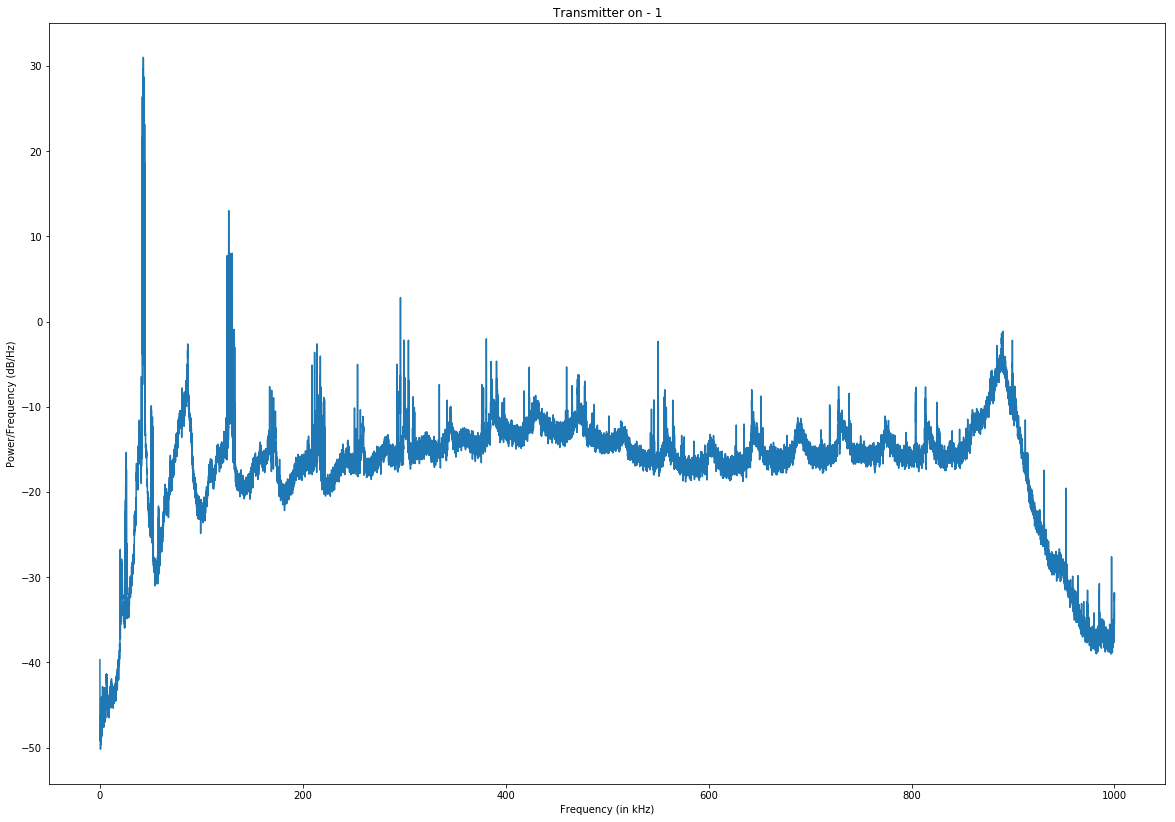

In [14]:
cnt = 1
plt.figure(figsize=(20,14))
plt.plot(f/1000,10*(np.log10(psd)))
plt.xlabel('Frequency (in kHz)')
plt.ylabel('Power/Frequency (dB/Hz)');
plt.title('Transmitter on - ' +str(cnt)); 
plt.savefig('Power_Density_plot.png')
plt.show()

 5. Write Raw data and psd data to text file

In [15]:
with (open('Raw_Data.txt','w')) as file:
    file.write(str(data)[1:-1])

for_Save=np.c_[(list(f/1e3),(10*np.log10(psd)))]
for_Save_n=''.join(','.join('%0.3f' %x for x in y) for y in for_Save)

with (open('post_fft_python.txt','w')) as file:
    file.write(str(for_Save_n))